In [ ]:
# Imports and setups
!pip install kagglehub --quiet

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import torch.nn.functional as F

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

import cv2
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.io import read_image


In [ ]:
import os
import math
from typing import Tuple, List

import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision.transforms as T
import torchvision.models as models

# Optional but recommended for wavelet features:
try:
    import pywt
    HAS_PYWT = True
except ImportError:
    HAS_PYWT = False
    print("[WARN] pywt not installed. Wavelet feature will be zeroed. Install with `pip install pywavelets`.")


In [ ]:
import kagglehub

path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")
print("Dataset path:", path)

Using Colab cache for faster access to the 'cifake-real-and-ai-generated-synthetic-images' dataset.
Dataset path: /kaggle/input/cifake-real-and-ai-generated-synthetic-images


In [ ]:
train_dir = f"{path}/train"
test_dir  = f"{path}/test"

Feature Extraction

# Gray Tensor

In [ ]:
def to_gray_tensor(img_tensor: torch.Tensor) -> torch.Tensor:
    """
    img_tensor: (3, H, W), values in [0,1]
    Returns: (1, H, W) grayscale
    """
    if img_tensor.shape[0] == 1:
        return img_tensor
    r, g, b = img_tensor[0], img_tensor[1], img_tensor[2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray.unsqueeze(0)

In [ ]:
def rgb_to_gray(rgb_batch: torch.Tensor) -> torch.Tensor:
    # rgb_batch: (B,3,H,W)
    r = rgb_batch[:, 0]
    g = rgb_batch[:, 1]
    b = rgb_batch[:, 2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray.unsqueeze(1)  # (B,1,H,W)


## Blurry

In [ ]:
def extract_blurry_patches_single(gray: torch.Tensor,
                                  ksize: int = 9,
                                  top_k: int = 64) -> torch.Tensor:
    """
    gray: (1, H, W) tensor, [0,1]
    returns: (K, 1, ksize, ksize) patches around blurriest locations
    """
    device = gray.device
    g = gray.unsqueeze(0)  # (1,1,H,W)

    # 1. Laplacian
    lap_kernel = torch.tensor([[0., -1., 0.],
                               [-1., 4., -1.],
                               [0., -1., 0.]], device=device).view(1, 1, 3, 3)
    lap = F.conv2d(g, lap_kernel, padding=1)  # (1,1,H,W)

    # 2. Local variance of Laplacian via mean / mean of squares
    w = torch.ones(1, 1, ksize, ksize, device=device) / (ksize * ksize)
    mean = F.conv2d(lap, w, padding=ksize // 2)
    mean_sq = F.conv2d(lap * lap, w, padding=ksize // 2)
    var = (mean_sq - mean * mean).squeeze(0).squeeze(0)  # (H, W)

    H, W = var.shape
    var_flat = var.view(-1)

    # 3. Take top_k lowest-variance (most blurry) positions
    top_k = min(top_k, var_flat.numel())
    _, idx = torch.topk(var_flat, k=top_k, largest=False)  # small variance first
    ys = idx // W
    xs = idx % W

    # 4. Extract patches
    pad = ksize // 2
    padded = F.pad(gray, (pad, pad, pad, pad), mode='reflect')  # (1,H+2p,W+2p)

    patches = []
    for y, x in zip(ys, xs):
        y = y.item()
        x = x.item()
        patch = padded[:, y:y+ksize, x:x+ksize]  # (1,ksize,ksize)
        patches.append(patch)

    patches = torch.stack(patches, dim=0)  # (K,1,ksize,ksize)
    return patches


In [ ]:
def high_pass_residual(gray: torch.Tensor) -> torch.Tensor:
    """
    Simple high-pass filter using Laplacian kernel.
    gray: (1, H, W)
    returns: (1, H, W)
    """
    kernel = torch.tensor([[ -1., -1., -1.],
                           [ -1.,  8., -1.],
                           [ -1., -1., -1.]], dtype=torch.float32, device=gray.device)
    kernel = kernel.view(1, 1, 3, 3)
    padding = 1
    residual = F.conv2d(gray.unsqueeze(0), kernel, padding=padding)
    residual = residual.squeeze(0)
    # Normalize
    residual = residual / (residual.abs().max() + 1e-8)
    return residual

In [ ]:

def prnu_residual(gray: torch.Tensor, sigma: float = 1.0) -> torch.Tensor:
    """
    Approximate PRNU: image - gaussian_blur(image).
    gray: (1, H, W)
    returns: (1, H, W)
    """
    # Use a separable Gaussian blur via conv
    radius = int(3 * sigma)
    x = torch.arange(-radius, radius + 1, device=gray.device, dtype=torch.float32)
    gauss_1d = torch.exp(-0.5 * (x / sigma) ** 2)
    gauss_1d = gauss_1d / gauss_1d.sum()
    gauss_1d = gauss_1d.view(1, 1, -1)

    # Horizontal
    blurred = F.conv2d(gray.unsqueeze(0), gauss_1d.unsqueeze(3), padding=(0, radius))
    # Vertical
    blurred = F.conv2d(blurred, gauss_1d.unsqueeze(2), padding=(radius, 0))
    blurred = blurred.squeeze(0)

    residual = gray - blurred
    residual = residual / (residual.abs().max() + 1e-8)
    return residual

In [ ]:

def fft_magnitude_map(gray: torch.Tensor) -> torch.Tensor:
    """
    Compute log-magnitude FFT map.
    gray: (1, H, W)
    returns: (1, H, W)
    """
    # Convert to numpy for simplicity then back to torch
    g = gray.squeeze(0).cpu().numpy()
    fft2 = np.fft.fft2(g)
    fft_shift = np.fft.fftshift(fft2)
    magnitude = np.log(1 + np.abs(fft_shift))

    # Normalize
    magnitude = (magnitude - magnitude.min()) / (magnitude.max() - magnitude.min() + 1e-8)
    mag_tensor = torch.from_numpy(magnitude).float().unsqueeze(0)
    return mag_tensor.to(gray.device)


In [ ]:

def wavelet_hh_band(gray: torch.Tensor) -> torch.Tensor:
    """
    Extract high-frequency HH band via wavelet transform.
    gray: (1, H, W)
    returns: (1, H, W) (upsampled back to original size if needed)
    """
    if not HAS_PYWT:
        # Fallback: zeros
        return torch.zeros_like(gray)

    g = gray.squeeze(0).cpu().numpy()
    coeffs2 = pywt.dwt2(g, 'haar')
    LL, (LH, HL, HH) = coeffs2
    hh = HH

    # Normalize
    hh = (hh - hh.min()) / (hh.max() - hh.min() + 1e-8)

    hh_tensor = torch.from_numpy(hh).float().unsqueeze(0).to(gray.device)
    # Resize back to original size using bilinear upsampling
    hh_tensor = F.interpolate(hh_tensor.unsqueeze(0),
                              size=gray.shape[1:],
                              mode='bilinear',
                              align_corners=False).squeeze(0)
    return hh_tensor


In [ ]:
def autocorrelation_map(gray: torch.Tensor) -> torch.Tensor:
    """
    Approximate local autocorrelation: correlate shifted versions.
    gray: (1, H, W)
    returns: (1, H, W) correlation magnitude map
    """
    g = gray

    # Shift horizontally and vertically
    g_right = F.pad(g[:, :, :, 1:], (0, 1, 0, 0), mode='reflect')
    g_down = F.pad(g[:, :, 1:, :], (0, 0, 0, 1), mode='reflect')

    # Compute local correlation approximation: product normalized
    eps = 1e-8
    mean = g.mean(dim=(2, 3), keepdim=True)
    std = g.std(dim=(2, 3), keepdim=True) + eps

    g_norm = (g - mean) / std
    g_right_norm = (g_right - mean) / std
    g_down_norm = (g_down - mean) / std

    corr_h = g_norm * g_right_norm
    corr_v = g_norm * g_down_norm

    corr = (corr_h + corr_v) / 2.0
    # Normalize to [0,1]
    corr_min = corr.min()
    corr_max = corr.max()
    corr = (corr - corr_min) / (corr_max - corr_min + 1e-8)

    return corr

In [ ]:
def extract_forensic_tensor(rgb_tensor: torch.Tensor) -> torch.Tensor:
    """
    Given RGB tensor (3, H, W) in [0,1], return forensic tensor (C_f, H, W)
    where C_f = 5 here.
    """
    gray = to_gray_tensor(rgb_tensor)  # (1, H, W)

    hpf = high_pass_residual(gray)
    prnu = prnu_residual(gray)
    # fft_map = fft_magnitude_map(gray)
    #wave_hh = wavelet_hh_band(gray)
    acorr = autocorrelation_map(gray.unsqueeze(0))  # returns (1,1,H,W)
    acorr = acorr.squeeze(0)  # (1,H,W)

    # Stack (5, H, W)
    forensic = torch.cat([hpf, prnu, acorr], dim=0)
    return forensic

Get The Dataset

In [ ]:
class AIRealDataset(Dataset):
    """
    Expects directory structure like:
    root_dir/
        real/
            img1.jpg
            img2.png
            ...
        fake/
            imgA.jpg
            imgB.png
            ...
    label: real -> 0, fake -> 1
    """

    def __init__(self, root_dir: str, image_size: int = 256):
        super().__init__()
        self.root_dir = root_dir
        self.classes = ['REAL', 'FAKE']
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}

        self.samples: List[Tuple[str, int]] = []
        for cls in self.classes:
            class_dir = os.path.join(root_dir, cls)
            if not os.path.isdir(class_dir):
                print(f"[WARN] Class directory not found: {class_dir}")
                continue
            for fname in os.listdir(class_dir):
                if fname.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.webp')):
                    path = os.path.join(class_dir, fname)
                    self.samples.append((path, self.class_to_idx[cls]))

        print(f"[INFO] Loaded {len(self.samples)} images from {root_dir}")

        # Basic transforms for RGB input (no heavy augment on noise!)
        self.transform = T.Compose([
            T.Resize((image_size, image_size)),
            T.ToTensor(),  # converts to [0,1]
        ])

        # Optional light augmentation for training (you can extend this)
        self.augment = T.Compose([
            T.RandomHorizontalFlip(p=0.5),
            T.RandomVerticalFlip(p=0.1),
            T.RandomRotation(degrees=5),
        ])

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: int):
        path, label = self.samples[idx]
        img = Image.open(path).convert('RGB')

        # Apply base transforms
        img = self.transform(img)  # (3,H,W)

        # Light augmentation that doesn't kill noise stats too much
        img = self.augment(img)

        # Extract forensic tensor
        forensic = extract_forensic_tensor(img)  # (5,H,W)

        return {
            "rgb": img,               # (3,H,W)
            "forensic": forensic,     # (5,H,W)
            "label": torch.tensor(label, dtype=torch.long)
        }



Two Stream Models

In [ ]:
class ForensicCNN(nn.Module):
    """
    Small CNN for forensic feature maps (5 channels in).
    """

    def __init__(self, in_channels: int = 1, out_dim: int = 256):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.fc = nn.Linear(128, out_dim)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


class ThreeStreamNet(nn.Module):
    """
    3-stream architecture:
      - RGB stream: EfficientNet-B0
      - Forensic stream: ForensicCNN over 5-channel forensic tensor
      - Blurry-patch stream: BlurryPatchEncoder over RGB
    """

    def __init__(self, num_classes: int = 2,
                 forensic_out_dim: int = 256,
                 patch_out_dim: int = 256):
        super().__init__()

        # RGB backbone: EfficientNet-B0
        effnet = models.efficientnet_b0(
            weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1
        )
        self.rgb_backbone = effnet.features
        self.rgb_pool = nn.AdaptiveAvgPool2d((1, 1))
        rgb_feat_dim = effnet.classifier[1].in_features  # typically 1280

        # Forensic backbone
        self.forensic_backbone = ForensicCNN(in_channels=3, out_dim=forensic_out_dim)

        # Blurry patch encoder
        # self.patch_encoder = BlurryPatchEncoder(
        #     patch_size=9,
        #     top_k=64,
        #     out_dim=patch_out_dim
        # )

        # Fusion
        fusion_dim = rgb_feat_dim + forensic_out_dim
        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, rgb, forensic):
        # RGB stream
        x_rgb = self.rgb_backbone(rgb)
        x_rgb = self.rgb_pool(x_rgb)
        x_rgb = x_rgb.view(x_rgb.size(0), -1)     # (B, rgb_feat_dim)

        # Forensic stream
        x_for = self.forensic_backbone(forensic)  # (B, forensic_out_dim)

        # Blurry patch stream
        #x_patch = self.patch_encoder(rgb)         # (B, patch_out_dim)

        # Fuse
        #x = torch.cat([x_rgb, x_for, x_patch], dim=1)
        x = torch.cat([x_rgb, x_for], dim=1)
        logits = self.classifier(x)
        return logits


class BlurryPatchEncoder(nn.Module):
    """
    Takes batch of RGB images, internally extracts blurry patches per image,
    runs them through a small CNN, aggregates to one vector per image.
    """

    def __init__(self, patch_size: int = 9, top_k: int = 64, out_dim: int = 256):
        super().__init__()
        self.patch_size = patch_size
        self.top_k = top_k

        # CNN for (1, patch_size, patch_size)
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.fc = nn.Linear(64, out_dim)

    def forward(self, rgb: torch.Tensor) -> torch.Tensor:
        """
        rgb: (B, 3, H, W)
        returns: (B, out_dim)
        """
        B, _, H, W = rgb.shape
        device = rgb.device

        # Convert to grayscale batch (B,1,H,W)
        gray = rgb_to_gray(rgb)

        feats = []
        for i in range(B):
            g = gray[i]  # (1,H,W)
            patches = extract_blurry_patches_single(
                g,
                ksize=self.patch_size,
                top_k=self.top_k
            )  # (K,1,ps,ps)

            # Run through CNN
            p_feats = self.cnn(patches)          # (K,64,1,1)
            p_feats = p_feats.view(p_feats.size(0), -1)  # (K,64)
            p_feats = self.fc(p_feats)           # (K,out_dim)

            # Aggregate over patches (mean pooling)
            img_feat = p_feats.mean(dim=0)       # (out_dim,)
            feats.append(img_feat)

        feats = torch.stack(feats, dim=0)        # (B,out_dim)
        return feats


In [ ]:
def train_one_epoch(model, dataloader, optimizer, device, epoch, loss_fn):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, batch in enumerate(dataloader):
        rgb = batch["rgb"].to(device)
        forensic = batch["forensic"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        logits = model(rgb, forensic)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * rgb.size(0)
        _, preds = logits.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    print(f"[TRAIN] Epoch {epoch}: Loss={epoch_loss:.4f}, Acc={epoch_acc:.4f}")
    return epoch_loss, epoch_acc


def eval_one_epoch(model, dataloader, device, epoch, loss_fn, mode="VAL"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.inference_mode():
        for batch in dataloader:
            rgb = batch["rgb"].to(device)
            forensic = batch["forensic"].to(device)
            labels = batch["label"].to(device)

            logits = model(rgb, forensic)
            loss = loss_fn(logits, labels)

            running_loss += loss.item() * rgb.size(0)
            _, preds = logits.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    print(f"[{mode}] Epoch {epoch}: Loss={epoch_loss:.4f}, Acc={epoch_acc:.4f}")
    return epoch_loss, epoch_acc


Training

In [ ]:
import matplotlib.pyplot as plt

def main():

    root_dir = train_dir
    image_size = 256
    batch_size = 16
    num_epochs = 20
    lr = 1e-4
    val_split = 0.2
    num_workers = 4
    seed = 42

    torch.manual_seed(seed)
    np.random.seed(seed)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[INFO] Using device: {device}")

    dataset = AIRealDataset(root_dir=root_dir, image_size=image_size)

    if len(dataset) == 0:
        raise RuntimeError(
            f"No images found in {root_dir}. "
            f"Check that the dataset is attached and folder names match (real/fake)."
        )

    n_total = len(dataset)
    n_val = int(val_split * n_total)
    n_train = n_total - n_val

    train_ds, val_ds = random_split(dataset, [n_train, n_val])

    train_loader = DataLoader(
        train_ds, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True
    )
    val_loader = DataLoader(
        val_ds, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=True
    )

    model = ThreeStreamNet(
        num_classes=2,
        forensic_out_dim=256,
        patch_out_dim=256
    ).to(device)

#     model = HPFOnlyNet(
#     num_classes=2,
#     forensic_out_dim=256
# ).to(device)




    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

    best_val_acc = 0.0

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    epochs_list = []
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', patience=2, factor=0.5)

    patience = 5
    patience_counter = 0
    for epoch in range(1, num_epochs + 1):
        print('epoch: ', epoch)
        train_loss, train_acc = train_one_epoch(
            model, train_loader, optimizer, device, epoch, loss_fn
        )
        val_loss, val_acc = eval_one_epoch(
            model, val_loader, device, epoch, loss_fn, mode="VAL"
        )

        epochs_list.append(epoch)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        scheduler.step(val_acc)


        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0  # reset patience
            save_path = "best_three_stream_detector.pt"
            torch.save(model.state_dict(), save_path)
            print(f"[INFO] New best model saved to {save_path} (val_acc={best_val_acc:.4f})")
        else:
            patience_counter += 1
            print(f"[INFO] No improvement. Patience counter = {patience_counter}")

        if patience_counter >= patience:
            print(f"[EARLY STOP] Validation accuracy did not improve for {patience} epochs.")
            break

    print(f"[DONE] Training finished. Best val acc = {best_val_acc:.4f}")

    plt.figure(figsize=(8, 5))
    plt.plot(epochs_list, train_losses, label="Train Loss")
    plt.plot(epochs_list, val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(epochs_list, train_accs, label="Train Acc")
    plt.plot(epochs_list, val_accs, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()



[INFO] Using device: cuda
[INFO] Loaded 100000 images from /kaggle/input/cifake-real-and-ai-generated-synthetic-images/train
epoch:  1
[TRAIN] Epoch 1: Loss=0.1541, Acc=0.9403
[VAL] Epoch 1: Loss=0.0821, Acc=0.9696
[INFO] New best model saved to best_three_stream_detector.pt (val_acc=0.9696)
epoch:  2
[TRAIN] Epoch 2: Loss=0.0876, Acc=0.9679
[VAL] Epoch 2: Loss=0.0622, Acc=0.9762
[INFO] New best model saved to best_three_stream_detector.pt (val_acc=0.9762)
epoch:  3
[TRAIN] Epoch 3: Loss=0.0700, Acc=0.9743
[VAL] Epoch 3: Loss=0.0517, Acc=0.9800
[INFO] New best model saved to best_three_stream_detector.pt (val_acc=0.9800)
epoch:  4
[TRAIN] Epoch 4: Loss=0.0577, Acc=0.9783
[VAL] Epoch 4: Loss=0.0518, Acc=0.9810
[INFO] New best model saved to best_three_stream_detector.pt (val_acc=0.9810)
epoch:  5
[TRAIN] Epoch 5: Loss=0.0495, Acc=0.9821
[VAL] Epoch 5: Loss=0.0522, Acc=0.9805
[INFO] No improvement. Patience counter = 1
epoch:  6
[TRAIN] Epoch 6: Loss=0.0435, Acc=0.9845
[VAL] Epoch 6: Los

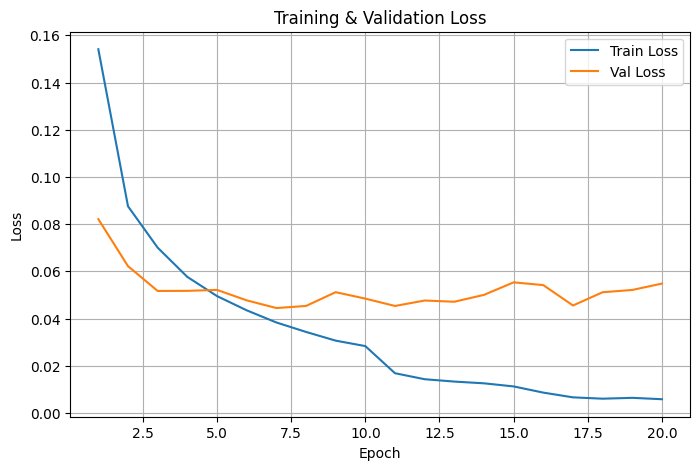

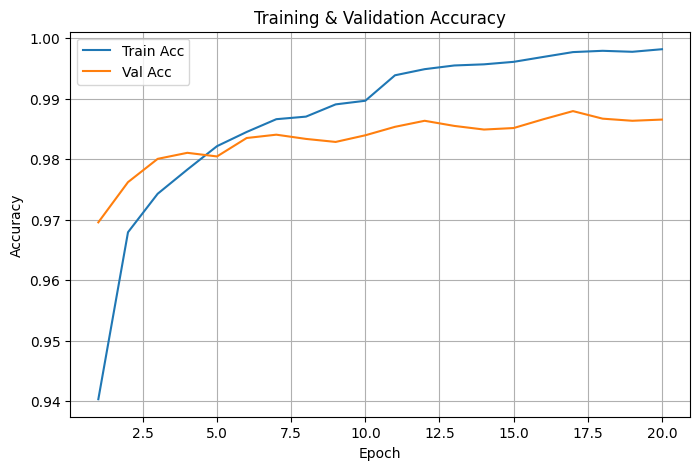

In [ ]:
main()

In [ ]:
import os
import shutil, zipfile


# Create zip file
with zipfile.ZipFile('best_model.zip', 'w') as z:
    z.write('best_three_stream_detector.pt')

In [ ]:
from google.colab import files
files.download("best_model.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def load_rgb_image(path, image_size=256):
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor()  # Converts to [0,1]
    ])
    img = Image.open(path).convert("RGB")
    rgb = transform(img)  # (3, H, W)
    return rgb
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ThreeStreamNet(
    num_classes=2,
    forensic_out_dim=256,
    patch_out_dim=256
).to(device)
state = torch.load("best_three_stream_detector.pt", map_location=device)
model.load_state_dict(state)
model.eval()


ThreeStreamNet(
  (rgb_backbone): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormA

In [ ]:
def extract_forensic_tensor_single(rgb):
    gray = to_gray_tensor(rgb)   # (1,H,W)

    hpf = high_pass_residual(gray)  # (1,H,W)
    prnu = prnu_residual(gray)      # (1,H,W)
    acorr = autocorrelation_map(gray.unsqueeze(0)).squeeze(0)  # (1,H,W)

    forensic = torch.cat([hpf, prnu, acorr], dim=0)  # (3,H,W)
    return forensic


In [ ]:
import torch.nn.functional as F

def predict_image(path):
    rgb = load_rgb_image(path).to(device)   # (3,256,256)
    forensic = extract_forensic_tensor_single(rgb).to(device)  # (3,256,256)

    rgb = rgb.unsqueeze(0)         # (1,3,H,W)
    forensic = forensic.unsqueeze(0)  # (1,3,H,W)

    with torch.no_grad():
        logits = model(rgb, forensic)
        probs = F.softmax(logits, dim=1)

    real_prob = probs[0][0].item()
    fake_prob = probs[0][1].item()

    print(f"Real probability: {real_prob:.4f}")
    print(f"Fake (AI) probability: {fake_prob:.4f}")

    if fake_prob > 0.5:
        print("🔎 Prediction: **AI-generated**")
    else:
        print("📷 Prediction: **Real photo**")

    return probs


In [ ]:
predict_image("/content/real_tuxedo.jpeg")

Real probability: 0.9361
Fake (AI) probability: 0.0639
📷 Prediction: **Real photo**


tensor([[0.9361, 0.0639]], device='cuda:0')

In [ ]:
with torch.no_grad():
    logits = model(rgb, forensic)
    probs = torch.softmax(logits, dim=1)
    print("probs:", probs)           # e.g. tensor([[0.95, 0.05]])
    pred_class = torch.argmax(probs, dim=1).item()
    print("predicted class index:", pred_class)


NameError: name 'rgb' is not defined

In [ ]:
fft_val = [0.7245,0.7512]
wavelet_val = [0.5467,0.5635]
autocorr_val = [0.7309, 0.8113]
blurPatch_val = [0.4909, 0.4909]
PRNU-only_val = [0.8519,0.8617]
HPF-Only_val = [0.8593,0.8688]
Edge = [0.5906]
RGB = [0.9395,0.9788]



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
categories = ['FFT', 'Wavelet', 'AutoCorr', 'Blur_Patch', 'PRNU', 'HPF', 'Edge_Detect','RGB']
values = [0.7512,0.5635,0.8113,0.4909,0.8617,0.8688,0.5906,0.9788]

# Option 1: Using a predefined colormap
# You can explore various colormaps like 'viridis', 'plasma', 'magma', 'cividis', 'Set2', 'Paired', etc.
colors = plt.cm.viridis(np.linspace(0, 1, len(categories)))

plt.figure(figsize=(8, 6))
plt.bar(categories, values, color=colors)
plt.xlabel('Feature Extractors')
plt.ylabel('Val_Accuracy')
plt.title('Validation Accuracies of Different Feature Extractors')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Test for fft only

In [ ]:
class FFTOnlyNet(nn.Module):
    def __init__(self, num_classes: int = 2, forensic_out_dim: int = 256):
        super().__init__()
        self.forensic_backbone = ForensicCNN(in_channels=1, out_dim=forensic_out_dim)
        self.classifier = nn.Sequential(
            nn.Linear(forensic_out_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes),
        )

    def forward(self, rgb, forensic):
        # rgb is ignored; we only use the FFT map in 'forensic'
        x_for = self.forensic_backbone(forensic)
        logits = self.classifier(x_for)
        return logits


Test for Wavelet

In [ ]:
class WaveletOnlyNet(nn.Module):
    def __init__(self, num_classes: int = 2, forensic_out_dim: int = 256):
        super().__init__()
        self.forensic_backbone = ForensicCNN(in_channels=1, out_dim=forensic_out_dim)
        self.classifier = nn.Sequential(
            nn.Linear(forensic_out_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes),
        )

    def forward(self, rgb, forensic):
        x_for = self.forensic_backbone(forensic)
        logits = self.classifier(x_for)
        return logits


Test for Autocorr

In [ ]:
class AutoCorrOnlyNet(nn.Module):
    def __init__(self, num_classes: int = 2, forensic_out_dim: int = 256):
        super().__init__()
        self.forensic_backbone = ForensicCNN(in_channels=1, out_dim=forensic_out_dim)
        self.classifier = nn.Sequential(
            nn.Linear(forensic_out_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes),
        )

    def forward(self, rgb, forensic):
        # rgb is ignored; we only use the autocorr feature
        x_for = self.forensic_backbone(forensic)
        logits = self.classifier(x_for)
        return logits


Test for Blur Batch

In [ ]:
class PatchOnlyNet(nn.Module):
    """
    Blur-only model: uses just the BlurryPatchEncoder stream.
    Ignores RGB global EfficientNet and forensic maps.
    """

    def __init__(self, num_classes: int = 2, patch_out_dim: int = 256):
        super().__init__()
        self.patch_encoder = BlurryPatchEncoder(
            patch_size=9,
            top_k=64,
            out_dim=patch_out_dim,
        )
        self.classifier = nn.Sequential(
            nn.Linear(patch_out_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes),
        )

    def forward(self, rgb, forensic):
        # forensic is ignored; we only use blur-based patch features
        x_patch = self.patch_encoder(rgb)   # (B, patch_out_dim)
        logits = self.classifier(x_patch)   # (B, num_classes)
        return logits


Test for HPF

In [ ]:
class HPFOnlyNet(nn.Module):
    def __init__(self, num_classes: int = 2, forensic_out_dim: int = 256):
        super().__init__()
        self.forensic_backbone = ForensicCNN(in_channels=1, out_dim=forensic_out_dim)
        self.classifier = nn.Sequential(
            nn.Linear(forensic_out_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes),
        )

    def forward(self, rgb, forensic):
        x_for = self.forensic_backbone(forensic)  # uses only HPF map
        logits = self.classifier(x_for)
        return logits


Test For PRNU

In [ ]:
class PRNUOnlyNet(nn.Module):
    def __init__(self, num_classes: int = 2, forensic_out_dim: int = 256):
        super().__init__()
        self.forensic_backbone = ForensicCNN(in_channels=1, out_dim=forensic_out_dim)
        self.classifier = nn.Sequential(
            nn.Linear(forensic_out_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes),
        )

    def forward(self, rgb, forensic):
        x_for = self.forensic_backbone(forensic)
        logits = self.classifier(x_for)
        return logits


Test for RGBOnlyNet

In [ ]:
class RGBOnlyNet(nn.Module):
    """
    RGB-only baseline:
    Uses EfficientNet-B0 on the raw RGB image.
    Ignores forensic maps and blur patches.
    """

    def __init__(self, num_classes: int = 2):
        super().__init__()

        effnet = models.efficientnet_b0(
            weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1
        )
        self.rgb_backbone = effnet.features
        self.rgb_pool = nn.AdaptiveAvgPool2d((1, 1))
        rgb_feat_dim = effnet.classifier[1].in_features  # usually 1280

        self.classifier = nn.Sequential(
            nn.Linear(rgb_feat_dim, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes),
        )

    def forward(self, rgb, forensic):
        # forensic is ignored; we only use the RGB image
        x = self.rgb_backbone(rgb)          # (B, C, H', W')
        x = self.rgb_pool(x)                # (B, C, 1, 1)
        x = x.view(x.size(0), -1)           # (B, C)
        logits = self.classifier(x)         # (B, num_classes)
        return logits
